### Self-Supervised Vision Transformers with DINO, ICCV2021
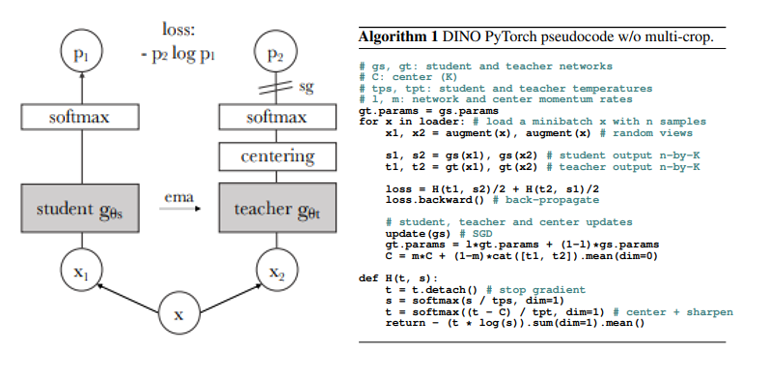
- 연구의 시작은 SSL(Self-Supervised Learning)을 ViT에 적용해보면 어떨까 라는 질문에서 시작
- DINO는 일반적인 knowledge-distillation 구조와는 다르게 Teacher network의 output을 student model의 output이 직접적으로 예측하는 간소화된 구조
- 즉, SSL + Knowledge Distillation

In [ ]:
'''
gs, gt: student and teacher networks
C: center K
tps, tpt: student and teacher temperature
l, m: networks and center momentum rates
'''
gt.params = gs.params
for x in loader: # load a minibatch x with n samples
    x1, x2 = augment(x), augment(x) # 2.  multi crop strategy

    s1, s2 = gs(x1), gs(x2) # student output n-by-k
    t1, t2 = gt(x1), gt(x2) # teacher output n-by-k

    loss = H(t1, s2) / 2 + H(t2, s1) / 2
    loss.backward()

    # student, teacher and center updates
    update(gs)
    gt.params = λ * gt.params + (1-λ) * gs.params # 3. momentum teacher
    C = m * C + (1-m) * cat([t1, t2]).mean(dim=0)

def H(t, s):
    t = t.detach() # stop gradient # 1. cross entropy
    s = softmax(s / tps, dim=1)
    t = softmax((t - C) / tpt, dim=1) # center + sharpen
    return - (t * log(s)).sum(dim=1).mean()

- Key idea는 `cross entropy, multi crop strategy, momentum teacher, centering, sharpening`

#### 1. cross entropy
- 같은 네트워크 구조를 갖는 model student와 teacher를 구성하고 teacher의 gradient는 동결하여 학습하지 않는다.
- sample x에 대해서 서로 다른 augmentation기법을 적용한 x1,x2를 각각 생성 후 student와 teacher에 통과시키고 두 모델의 softmax 확률 값을 cross entropy loss로 최적화

#### 2.  multi crop strategy
- Augmentation에서 사용되는 multi crop의 경우 global view와 local view로 나눠집니다
- Global view는 sample의 원래 크기에서 50% 이상의 크기로 crop후 resize ==> Teacher 네트워크에 적용
- Local view는 50%이하로 crop해서 resize ==> Teacher, Student 네트워크에 적용
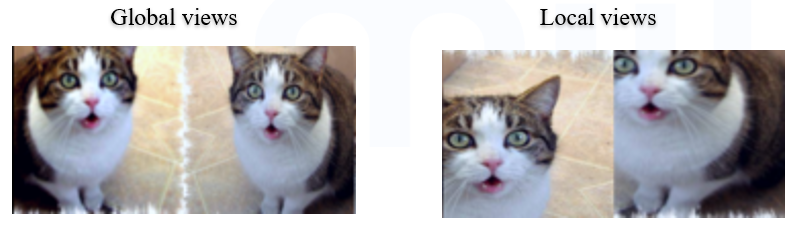 
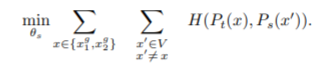

#### 3. momentum teacher
- 일반적인 knowledge distllation과는 다르게 DINO에서 Teacher network는 student에 비해 이전에 학습된 parameter를 사용하고 있지 않는다.
- Student network를 먼저 생성하여 같은 구조의 모델을 사용하되,
- teacher network의 gradient는 동결시킨 후, student의 parameter를 EMA(Exponential moving average) 기법을 적용하여 parameter update을 진행
- λ는 hyper parameter로 저자들은 0.996~1이 되도록 cosine schedule을 사용
- 이런 방식으로 teacher model의 parameter를 업데이트 하면 결국 학습 단계에서 봤던 student model들의 parameter의 평균이 되는 것과 유사한데, 이는 모델 앙상블의 효과를 갖을 수 있다(?)
  


#### 4. sharpening (해당 클래스가 돋보이게 한다)
- 여느 SSL 연구들과 마찬가지로 발생할 수 있는 collapse가 존재하는데 여러 SSL 연구에서는 contrastive loss, clustering constraints, predictor or batch normalization과 같은 방법들을 사용
- DINO에서는 centering과 sharpening을 적용해서 학습에서 생길 수 있는 문제점을 보완
- Sharpening은 network의 output 확률 분포를 조절 하는 방법으로 temperature 라는 hyper parameter로 model의 출력값을 나눈 후 softmax를 취하는 방법
- Temperature는 1보다 작은 값을 사용할 때, 0에 가까울 수록 더욱 돋보이는 확률 값으로 분포가 변화
- $$ Sharpening: P_s(x)^{(i)} = \frac{exp(g_{\theta_{s}}(x)^{(i)} / \tau_s)}{\sum^K_{k=1}exp(g_{\theta_{s}}(x)^{(k)} / \tau_s)} $$
- τs: temperature of student / τt: temperature of teacher
  
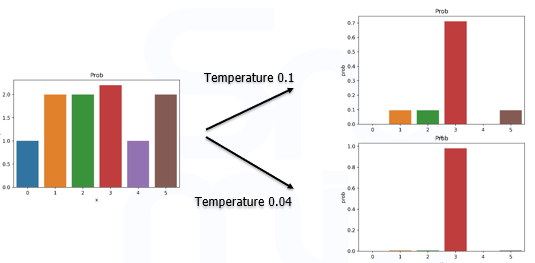

#### 5. centering
- Centering은 teacher model output에 c라는 bias term을 추가한 효과를 낸다.
- c의 초기값은 첫번째 batch의 output 평균 값으로 이후에는 m(hyper parameter)이라는 0보다 큰 비율로 업데이트를 합니다
- Centering은 모델의 출력이 하나의 차원으로만 직결되는 상황을 막을 수 있지만, 반대로 출력값의 분포가 uniform distribution을 따르도록 하는 문제점을 야기(??)
- Sharpening은 centering과 반대의 효과를 주기에, 두 기법을 모두 사용하여 학습함으로써 적절한 벨런스를 유지할 수 있었다(??)
  
  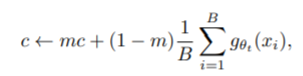
  
==> 요약, 
- student, teacher 서로 다른 augmented 된 데이터 입력 주입
- student, teacher 동일 구조, teacher의 params는 student params을 이용해 EMA로 업데이트
- sharpening과 centering 적용. 둘다 사용해야지 collapse 문제 해결.

<성능>  
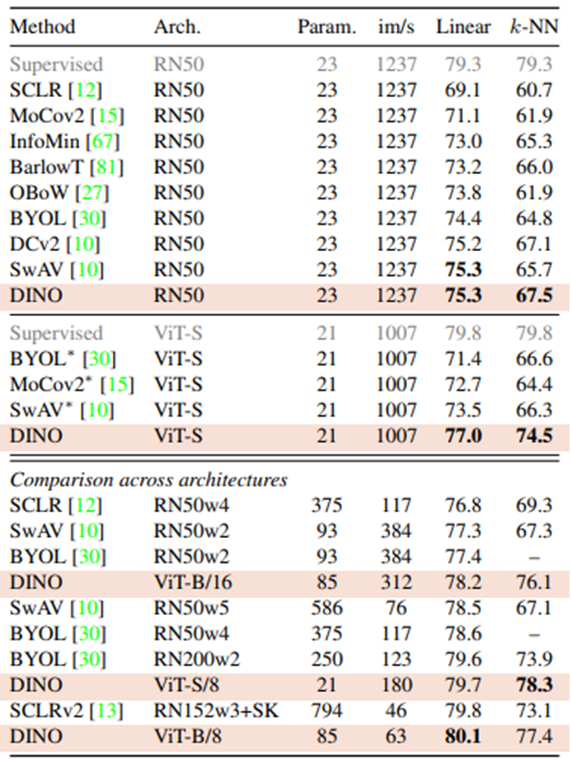

/home/user/DATA_LOCAL2/01_SelfSup/dino/vision_transformer.py

설명 더 듣기
https://www.youtube.com/watch?v=cqTUuZldJfU